<a href="https://colab.research.google.com/github/JamesHorrex/AI_stock_trading/blob/master/SS_AITrader_INTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-u1gg8kd7
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-u1gg8kd7
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.087622f0d4888b557639c605c04a0e822874df5ba_-cp36-none-any.whl size=123835 sha256=6bd4575d9ab5558f18a03de08bb32ffe50026b9f6c5c612e189fbdd90ce56612
  Stored in directory: /tmp/pip-ephem-wheel-cache-boryl4mq/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
import pandas as pd 
df=pd.read_csv('gdrive/My Drive/SS_AITrader/INTC/df_INTC_20drtn_features.csv')

In [7]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
0,2008-03-06,40.660631,38.532123,47.682059,42.211817,-70.344783,-72.258031,-76.630420,-64.660174,36.127340,43.167164,49.319174,40.737450,-1.633663,-0.699647,-3.025861,-2.118219,-0.251000,-0.142818,-0.281087,-0.403385,-0.343021,-0.367354,-0.367354,-0.367354,-0.367354,-32.863803,-49.411299,-72.498738,-81.790682,-40.574256,-62.103972,0.102567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298544,-0.026988,0.277627,-0.078746,0.503892,-0.050750,27.549999,2.949999,4.019999,-6.767833e+06,-6.767833e+06,-6.767833e+06,-6.767833e+06,0.124196,-0.067327,0.050321,-0.040717,0.053382,2.257,0.044,0.397,-0.480003,-0.720001,1.0
1,2008-03-07,46.573844,37.420182,51.393327,44.236725,-56.551748,-59.354873,-65.760918,-60.776702,48.321503,49.237124,54.296974,40.598457,1.006537,0.349998,0.500753,1.261352,0.099753,-0.143791,-0.268838,-0.389764,-0.344204,-0.350031,-0.350031,-0.350031,-0.350031,41.542859,-25.948181,-37.573545,-59.825841,-33.675455,-53.184008,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277249,-0.023644,0.279008,-0.079723,0.501047,-0.044776,27.490000,-0.059999,0.949999,4.024298e+05,4.024298e+05,4.024298e+05,4.024298e+05,0.198279,-0.007957,0.036069,-0.052654,0.124612,2.141,-0.116,0.392,0.029999,-0.680000,1.0
2,2008-03-10,55.908911,45.530486,50.640208,42.899689,-53.103390,-56.128991,-63.043465,-59.805806,57.981624,55.310678,54.685329,42.649824,0.249134,-0.396039,0.549728,0.902710,-0.740008,-0.140474,-0.256326,-0.376074,-0.345033,-0.328481,-0.328481,-0.328481,-0.328481,105.285649,0.555589,2.600553,-29.042400,-27.071237,-44.018352,0.283021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.276145,-0.013426,0.276274,-0.059590,0.500913,-0.042373,29.379999,1.889999,3.099998,1.384759e+06,1.384759e+06,1.384759e+06,1.384759e+06,0.075067,0.002707,-0.008093,-0.068587,-0.091276,2.138,-0.003,0.239,-0.040001,-0.709999,1.0
3,2008-03-11,68.852448,62.777601,57.491014,46.619104,-1.123515,-1.123515,-4.347822,-38.834940,57.926355,55.866604,55.462219,44.846175,5.367793,6.693507,6.000004,2.464960,2.514509,-0.102405,-0.233546,-0.358031,-0.344999,-0.221700,-0.221700,-0.221700,-0.221700,166.666667,174.400623,183.937345,156.427093,-21.192620,-35.203272,0.974028,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.340100,0.050959,0.329509,0.003936,0.516776,0.010349,26.360001,-3.019999,0.840000,2.906066e+07,2.906066e+07,2.906066e+07,2.906066e+07,0.101039,0.099324,0.019964,-0.043356,0.166793,2.156,0.018,0.172,0.290001,-0.380005,1.0
4,2008-03-12,57.313777,60.542935,53.512051,47.694459,-18.048735,-18.048735,-18.048735,-40.388336,56.376682,55.241646,55.350611,44.236520,-0.377358,5.231695,4.554456,1.685125,1.052637,-0.050241,-0.205076,-0.337179,-0.344218,-0.141895,-0.141895,-0.141895,-0.141895,100.055721,169.801772,183.266059,181.742481,-17.498057,-29.007170,0.274512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.341488,0.053335,0.328144,0.054617,0.500548,-0.005994,27.219999,0.859999,2.619999,1.795952e+07,1.795952e+07,1.795952e+07,1.795952e+07,0.001913,0.065260,-0.017603,-0.066345,-0.321456,2.043,-0.113,-0.170,-0.879997,-1.080002,1.0


In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [9]:
from_date='2010-01-01'
to_date='2020-01-01'

In [10]:
df = df[pd.to_datetime(from_date) < df['timestamp'] ]
df = df[pd.to_datetime(to_date) > df['timestamp'] ]


In [11]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
445,2010-01-05,88.094170,59.988121,60.366862,62.443679,-7.881763,-7.881763,-7.881763,-6.986890,84.508746,64.004296,51.461356,58.963679,-0.047885,1.359887,2.807890,6.316871,2.003919,0.208069,0.121516,0.079198,0.068829,0.263919,0.263919,0.263919,0.263919,72.858574,124.071678,122.060233,149.608428,37.029144,39.108391,0.692310,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.172557,-0.082232,0.220345,-0.017996,0.235775,-0.006716,19.350000,-0.690001,-0.580000,5.291282e+06,5.291282e+06,5.291282e+06,5.291282e+06,0.122068,-0.031207,-0.009560,0.109600,0.095329,3.695,-0.091,-0.092,0.090004,-0.009995,0.0
446,2010-01-06,80.946726,63.065685,53.907302,60.682095,-21.296432,-11.330117,-11.330117,-10.407301,71.483848,58.168648,51.815635,56.863279,-0.335417,1.960782,1.960782,3.534092,2.110940,0.232049,0.136827,0.089088,0.069978,0.278762,0.278762,0.278762,0.278762,41.938952,96.555056,100.823189,135.994272,36.948244,40.089311,0.499996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.148330,-0.106689,0.220031,-0.018330,0.236248,-0.005672,19.160000,-0.190001,-0.850000,2.593294e+06,2.593294e+06,2.593294e+06,2.593294e+06,0.017669,-0.018439,-0.016087,0.109229,-0.235310,3.763,0.068,0.049,-0.130005,-0.340004,0.0
447,2010-01-07,64.942161,58.520916,52.482434,59.152553,-43.000031,-21.182274,-21.182274,-19.457019,57.438042,57.092324,52.302182,54.199527,-0.961533,-1.340990,0.048568,2.794408,3.051529,0.243208,0.148740,0.097873,0.071200,0.271260,0.271260,0.271260,0.271260,-69.288222,17.020424,56.798063,83.665768,37.812073,41.457802,0.619048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160247,-0.088743,0.211418,-0.015368,0.228726,-0.013237,19.059999,-0.100000,-0.900000,-1.873883e+06,-1.873883e+06,-1.873883e+06,-1.873883e+06,0.104499,0.023701,0.012776,0.089864,0.349775,3.777,0.014,0.033,0.420006,0.000000,0.0
448,2010-01-08,72.460205,64.507840,59.972902,57.821254,-22.988571,-9.852251,-9.852251,-9.049804,59.610881,68.742141,58.052285,54.010139,1.116503,-0.191667,2.107845,3.631838,4.097949,0.251795,0.159821,0.106530,0.072605,0.280638,0.280638,0.280638,0.280638,-33.898533,48.611014,73.495745,101.037032,39.809506,43.911289,0.877552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165674,-0.054949,0.214106,-0.016378,0.230001,-0.002195,18.129999,-0.930000,-3.550001,2.448731e+06,2.448731e+06,2.448731e+06,2.448731e+06,0.227456,0.175603,0.016272,0.120819,-0.107451,3.768,-0.009,-0.025,-0.440002,-0.389999,0.0
449,2010-01-11,73.166375,73.928139,60.836557,58.188132,-20.201909,-9.302274,-9.302274,-8.583642,63.603697,76.621834,58.515875,53.844248,0.576096,0.721161,0.335257,3.049684,3.970229,0.260240,0.170711,0.115293,0.074219,0.294360,0.294360,0.294360,0.294360,121.951151,113.941501,115.579059,136.439246,42.390088,46.483085,0.393943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160540,-0.042103,0.213775,-0.028653,0.226701,-0.011349,17.549999,-0.580000,-2.490002,3.675957e+06,3.675957e+06,3.675957e+06,3.675957e+06,0.155483,0.240898,-0.005402,0.099318,0.059121,3.793,0.025,0.007,-0.470001,-0.529999,0.0


In [12]:
df.tail()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
2890,2019-12-20,81.171475,53.502512,55.576257,68.938236,-3.831358,-3.030257,-5.325451,-3.454898,66.697561,52.395242,51.245389,62.315739,1.708077,2.879584,2.007267,3.766941,1.253864,0.011669,0.071105,0.153359,0.211403,0.370225,0.370225,0.370225,0.370225,136.668725,166.107862,153.525795,105.687716,6.849211,18.457885,0.913794,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.127922,-0.052370,0.176287,0.015929,0.244374,0.000140,12.51,0.010000,-0.120000,1.906994e+07,1.906994e+07,1.906994e+07,1.906994e+07,0.112977,-0.007743,0.048374,0.227646,1.647905,0.389,0.014,0.093,0.290001,0.540001,1.0
2891,2019-12-23,78.828982,58.498575,55.225708,68.530471,-16.467042,-13.647628,-13.647628,-13.221136,73.706785,58.760766,55.928619,60.667101,0.474977,3.603291,2.651644,4.776226,2.812010,0.044357,0.075870,0.149363,0.210010,0.471450,0.471450,0.471450,0.471450,115.730736,185.218543,190.066008,163.294973,7.374777,18.041882,0.256756,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.118447,-0.058606,0.171730,0.011575,0.140141,-0.102263,12.61,0.099999,0.469999,1.491529e+07,1.491529e+07,1.491529e+07,1.491529e+07,0.112598,-0.002632,0.049746,0.154020,-0.527696,0.415,0.026,0.048,-0.029999,0.610001,1.0
2892,2019-12-27,85.510220,84.690099,56.818174,62.651959,-11.299367,-9.852157,-8.456612,-8.230405,76.617325,73.999003,57.253781,60.668570,0.434641,1.435087,3.657700,4.396182,2.683308,0.155483,0.108631,0.149739,0.207089,0.743348,0.743348,0.743348,0.743348,124.827281,120.108653,149.686578,177.015556,12.719219,21.234235,0.310346,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.114245,-0.002985,0.155508,-0.011024,0.138726,-0.103650,13.43,0.780001,0.850000,6.854461e+06,6.854461e+06,6.854461e+06,6.854461e+06,0.084341,0.096177,-0.013908,0.134476,0.226954,0.356,-0.014,-0.019,-0.669998,-0.490005,1.0
2893,2019-12-30,73.578960,77.865976,56.145361,60.019465,-24.293796,-21.287139,-18.181833,-17.695484,68.986319,69.383163,56.729646,61.138601,-0.765651,0.353474,1.136553,3.166634,2.704565,0.183981,0.121243,0.152211,0.206427,0.767204,0.767204,0.767204,0.767204,11.796019,69.640283,96.806384,126.591584,13.448403,21.092651,0.358207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.129173,0.001251,0.155348,-0.020939,0.140478,-0.103895,14.82,1.389999,2.320000,2.614551e+06,2.614551e+06,2.614551e+06,2.614551e+06,0.087037,0.065820,-0.023178,0.107934,-0.094798,0.405,0.049,0.016,-0.180000,-0.680000,1.0
2894,2019-12-31,74.561553,76.455953,60.545155,60.965044,-17.796636,-15.594082,-13.319263,-13.319263,68.315588,74.098458,61.133981,60.999423,0.385776,0.050148,1.046765,3.726166,3.798125,0.206181,0.133265,0.155153,0.205861,0.795500,0.795500,0.795500,0.795500,-0.506596,59.875017,84.433830,114.891596,17.126942,23.703142,0.859646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126477,0.008030,0.152546,-0.019184,0.140542,0.000401,13.78,-1.040000,1.270000,2.849554e+06,2.849554e+06,2.849554e+06,2.849554e+06,0.225289,0.140009,0.035403,0.104730,0.131948,0.414,0.009,-0.001,-0.349998,-1.320000,1.0


In [13]:
df.drop(['timestamp'], inplace=True, axis=1)

In [14]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [15]:
train_dataset.head()

,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
1856,77.337272,66.791752,64.746761,56.148006,-4.843309,-4.843309,-4.843309,-2.611369,72.510485,64.617069,64.091466,57.932959,2.294326,3.550099,8.518772,7.030176,9.431973,0.189012,0.113286,0.036206,-0.119178,0.408838,0.408838,0.408838,0.408838,146.643023,153.779691,185.006735,237.459762,37.584665,33.396789,0.792683,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.241987,0.061342,0.234874,-0.012294,0.313282,0.019449,19.540001,-1.400000,-8.089998,1.519853e+07,1.519853e+07,1.519853e+07,1.519853e+07,0.209174,0.125901,0.142780,0.027616,0.248768,2.048,6.700003e-02,-0.034,0.279999,0.080002,1.0
2747,17.919059,23.937125,14.794672,35.155595,-86.239805,-87.933113,-93.623748,-93.742265,28.455734,26.161332,17.774470,40.408690,2.066110,-2.350098,-1.571838,-11.925516,-24.362028,-1.035381,-0.624450,-0.329969,0.069454,-2.728760,-2.728760,-2.728760,-2.728760,-47.489055,-76.597037,-76.788863,-101.594901,-167.753235,-163.020303,0.466666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.360573,0.022963,0.407393,-0.015586,0.340838,0.006576,14.950000,-1.360000,-3.110000,-6.685846e+06,-6.685846e+06,-6.685846e+06,-6.685846e+06,-0.361085,-0.206077,-0.214768,-0.097019,-0.109210,0.096,2.384186e-07,0.030,0.129997,0.529999,1.0
898,71.811485,79.625648,67.354515,67.465085,-10.328691,-8.058648,-4.583358,-3.642404,70.055854,76.424314,75.926761,66.963545,-0.596895,1.421033,3.953387,6.297870,17.057167,0.632725,0.496204,0.367681,0.061694,0.869203,0.869203,0.869203,0.869203,58.757780,89.188585,106.606252,125.705704,132.636951,145.149328,0.833330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.284667,0.008741,0.281566,-0.041594,0.286870,-0.003882,24.530001,-0.929998,-6.789999,1.491647e+07,1.491647e+07,1.491647e+07,1.491647e+07,0.266808,0.354598,0.339677,0.185834,-0.469042,2.296,-8.899999e-02,0.108,0.219994,-1.210007,0.0
765,78.607801,63.542796,63.741249,48.158153,-1.477866,-1.442341,-1.442341,-24.632362,70.664686,57.209508,61.206478,46.858827,7.804628,8.405063,8.240643,7.318291,5.519955,-0.119280,-0.183187,-0.177816,-0.052965,-0.109662,-0.109662,-0.109662,-0.109662,166.666667,282.640309,344.501477,305.586627,-38.056291,-44.361087,0.939999,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.419274,0.223288,0.323418,0.167374,0.275300,0.068467,15.070000,-0.760000,-1.850000,9.328566e+07,9.328566e+07,9.328566e+07,9.328566e+07,0.341105,0.203291,0.209806,0.048827,1.143706,3.345,4.400015e-02,-0.071,-0.659996,-0.610001,1.0
1100,11.905742,29.085454,35.987527,45.616104,-93.364954,-93.636388,-93.636388,-92.792797,7.982584,29.145659,41.800846,48.970655,-0.281010,-3.458995,-5.299273,-6.931436,-3.571429,-0.076555,0.009456,-0.003500,-0.047808,-0.205294,-0.205294,-0.205294,-0.205294,-73.785697,-123.142254,-169.136880,-159.130303,7.976485,3.751679,0.473684,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.155525,0.030485,0.151519,0.006465,0.202721,-0.022653,16.350000,1.170000,2.330000,-9.161790e+06,-9.161790e+06,-9.161790e+06,-9.161790e+06,-0.240986,-0.095476,-0.098448,-0.050344,-0.238181,1.554,-3.399992e-02,-0.175,0.070007,-0.799995,0.0


In [16]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [17]:
train_labels.head()

1856    1.0
2747    1.0
898     0.0
765     1.0
1100    0.0
Name: labels, dtype: float64

In [18]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [19]:
get_sample_weights(train_labels)

real class weights are [1.2039312  0.85514834] [0 1]
value_counts (array([0, 1]), array([ 814, 1146]))


1856    0.855148
2747    0.855148
898     1.203931
765     0.855148
1100    1.203931
          ...   
2051    1.203931
1301    1.203931
2192    1.203931
1640    0.855148
2882    0.855148
Name: labels, Length: 1960, dtype: float64

In [20]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [1.2039312  0.85514834] [0 1]
value_counts (array([0, 1]), array([ 814, 1146]))


In [21]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [22]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [23]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

k=20
list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('rsi_40',
 'wr_40',
 'trix_10',
 'trix_15',
 'trix_20',
 'trix_40',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'kst_20',
 'kst_40',
 'bb_l20',
 'realised_vol_change_5d_10',
 'realised_vol_20',
 'realised_vol_change_5d_20',
 'realised_vol_40',
 'vix_level',
 'cmf_10',
 'curve')

In [24]:
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('rsi_40',
 'mfi_15',
 'mfi_40',
 'roc_5',
 'roc_20',
 'trix_15',
 'trix_20',
 'trix_40',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'kst_20',
 'kst_40',
 'bb_l20',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_40',
 'cmf_40',
 'curve')

In [25]:
list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]
#kbest=SelectKBest(f_classif, k=10)
#X_train_new = kbest.fit_transform(normed_train_data, train_labels)
#X_test_new = kbest.transform(normed_test_data)

X_test_new.shape
X_test_new.head()

,rsi_40,mfi_15,mfi_40,roc_5,roc_20,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,kst_20,kst_40,bb_l20,realised_vol_10,realised_vol_20,realised_vol_40,cmf_40,curve
445,0.973555,0.710714,0.675997,0.769026,0.147605,0.355106,0.201744,0.232758,0.284736,0.284736,0.284736,0.284736,0.427696,0.429180,-0.229357,-0.514733,-0.138940,-0.015537,0.498823,2.013397
448,0.522255,1.000550,0.191656,0.561477,0.464578,0.523496,0.344201,0.264161,0.313917,0.313917,0.313917,0.313917,0.474803,0.507756,-0.229357,-0.583663,-0.213823,-0.098341,0.593471,2.093196
452,0.622743,1.128544,0.304219,1.203058,1.128622,0.676796,0.509139,0.322723,0.399253,0.399253,0.399253,0.399253,0.624606,0.646086,-0.229357,0.054854,0.013408,-0.024134,1.068418,2.006838
469,-0.387257,-0.687833,-0.175694,-0.450624,-1.095016,-0.649090,-0.233933,0.250308,-0.627629,-0.627629,-0.627629,-0.627629,-0.763337,-0.690825,-0.229357,0.891178,1.235300,0.621630,-1.269136,1.836308
470,-0.433166,-0.506156,0.003744,-0.048392,-0.831420,-0.716911,-0.307933,0.220311,-0.600918,-0.600918,-0.600918,-0.600918,-0.830969,-0.760711,-0.229357,0.808813,1.195436,0.598204,-1.165270,1.902990


In [26]:
def build_model(hidden_dim,dropout=0.5):
    ## input layer
    inputs=tf.keras.Input(shape=(X_train_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=2,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [48]:
tf.random.set_seed(1)

criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [28]:
example_batch = X_train_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.51365674, 0.48634326],
       [0.4288477 , 0.57115227],
       [0.49192256, 0.50807744],
       [0.5136658 , 0.48633423],
       [0.49632645, 0.50367355],
       [0.53177094, 0.46822906],
       [0.49101058, 0.50898945],
       [0.49043217, 0.50956786],
       [0.48688278, 0.5131172 ],
       [0.4953942 , 0.50460577]], dtype=float32)

In [29]:
EPOCHS=200
BATCH_SIZE=20

history = model.fit(
  X_train_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,shuffle=True,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/200
77/79 [============================>.] - ETA: 0s - loss: 0.7224 - accuracy: 0.5156
Epoch: 0, accuracy:0.5166,  loss:0.7212,  val_accuracy:0.4796,  val_loss:0.6941,  
79/79 [==============================] - 1s 8ms/step - loss: 0.7212 - accuracy: 0.5166 - val_loss: 0.6941 - val_accuracy: 0.4796
Epoch 2/200
79/79 [==============================] - 0s 6ms/step - loss: 0.7037 - accuracy: 0.5223 - val_loss: 0.6880 - val_accuracy: 0.5306
Epoch 3/200
79/79 [==============================] - 0s 6ms/step - loss: 0.6968 - accuracy: 0.5128 - val_loss: 0.6844 - val_accuracy: 0.5791
Epoch 4/200
79/79 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.5421 - val_loss: 0.6788 - val_accuracy: 0.6020
Epoch 5/200
79/79 [==============================] - 0s 6ms/step - loss: 0.6939 - accuracy: 0.5523 - val_loss: 0.6797 - val_accuracy: 0.5332
Epoch 6/200
79/79 [==============================] - 0s 6ms/step - loss: 0.6885 - accuracy: 0.5389 - val_loss: 0.6740 - val_accur

In [30]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.372049,0.846301,0.368536,0.821429,195
196,0.371847,0.838648,0.370383,0.826531,196
197,0.363184,0.834821,0.373079,0.836735,197
198,0.367755,0.842474,0.387143,0.831633,198
199,0.366662,0.833546,0.368677,0.841837,199


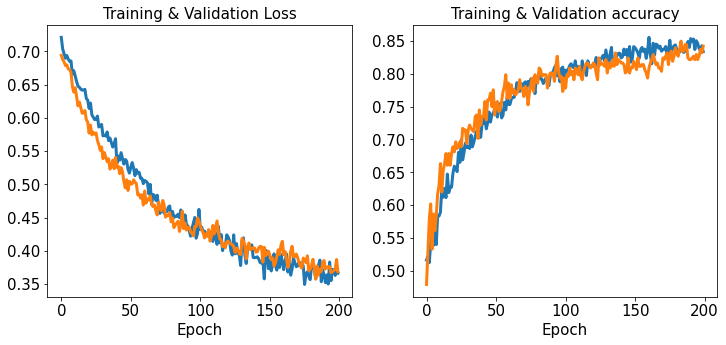

In [31]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()




In [32]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394130 sha256=fa7a3695c4152743202e7de8bd95b7d76cec14ad3ea03f3ef255b7369251cec7
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [33]:
import shap

explainer = shap.DeepExplainer(model, np.array(X_train_new))

Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.


In [34]:
shap_values  = explainer.shap_values(np.array(X_test_new))

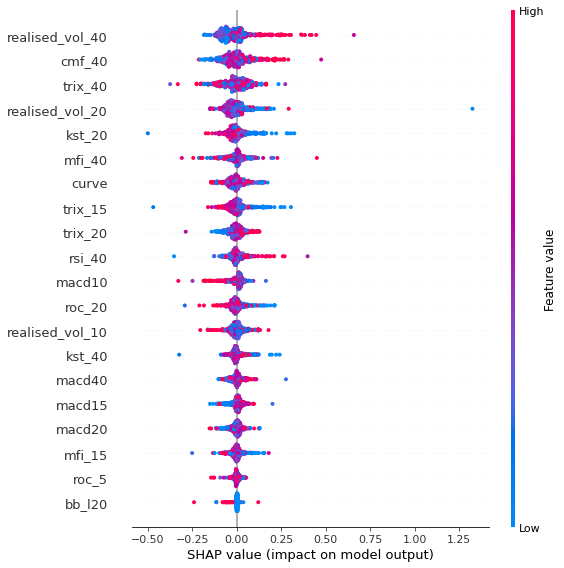

In [35]:
shap.summary_plot(shap_values[1], X_test_new)

In [36]:
pred=model.predict(X_test_new)
pred.argmax(axis=1)

array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix


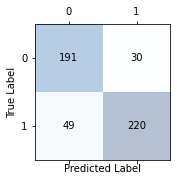

In [38]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [39]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('Recall: %.3f' % recall_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('F1: %.3f' % f1_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

Precision: 0.880
Recall: 0.818
F1: 0.848


In [40]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [41]:
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic'))
])

In [43]:
search_space = [
  {
    'clf__n_estimators': [200],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [mutual_info_classif,f_classif],
    'fs__k': [20,30,40],
  }
]

In [44]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [45]:
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [46]:
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

In [47]:
model = grid.fit(normed_train_data, train_labels)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed: 25.1min finished


In [49]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
pickle.dump(grid.best_estimator_, open('gdrive/My Drive/SS_AITrader/INTC/xgb_INTC_log_reg.pickle', "wb"))

In [50]:
predict = model.predict(normed_test_data)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(test_labels, predict)))
cm=confusion_matrix(test_labels,predict)

ValueError: ignored

Confusion Matrix


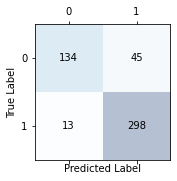

In [101]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [102]:
print(model.best_params_)

{'clf__colsample_bytree': 0.2, 'clf__gamma': 0.1, 'clf__learning_rate': 0.1, 'clf__max_depth': 9, 'clf__n_estimators': 200, 'fs__k': 40, 'fs__score_func': <function mutual_info_classif at 0x7fedf81f00d0>}


In [51]:
model_opt = xgb.XGBClassifier(max_depth=9,
                        objective='binary:logistic',
                        n_estimators=200,
                        learning_rate = 0.1,
                        colsample_bytree= 0.2,
                        gamma= 0.1)
eval_set = [(X_train_new, train_labels), (X_test_new, test_labels)]
model_opt.fit(X_train_new, train_labels, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.262245	validation_0-logloss:0.666199	validation_1-error:0.353061	validation_1-logloss:0.678182
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.167857	validation_0-logloss:0.632271	validation_1-error:0.320408	validation_1-logloss:0.660471
[2]	validation_0-error:0.139286	validation_0-logloss:0.610981	validation_1-error:0.306122	validation_1-logloss:0.649325
[3]	validation_0-error:0.112245	validation_0-logloss:0.577976	validation_1-error:0.279592	validation_1-logloss:0.630241
[4]	validation_0-error:0.1	validation_0-logloss:0.553261	validation_1-error:0.283673	validation_1-logloss:0.617323
[5]	validation_0-error:0.09898	validation_0-logloss:0.54185	validation_1-error:0.263265	validation_1-logloss:0.611882
[6]	validation_0-error:0.097449	validation_0-logloss:0.527882	validation_1-error:0.255102	validation_1-logloss:0.602737
[7

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [52]:

# make predictions for test data
y_pred = model_opt.predict(X_test_new)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.90%


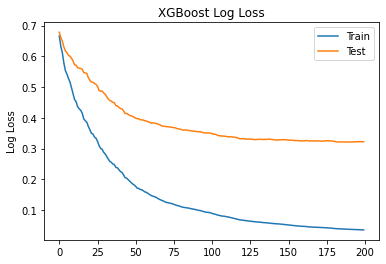

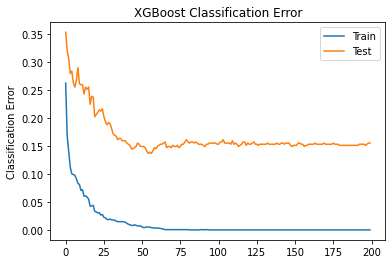

In [53]:
from matplotlib import pyplot

results = model_opt.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [54]:
shap_values = shap.TreeExplainer(model_opt).shap_values(X_test_new) 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


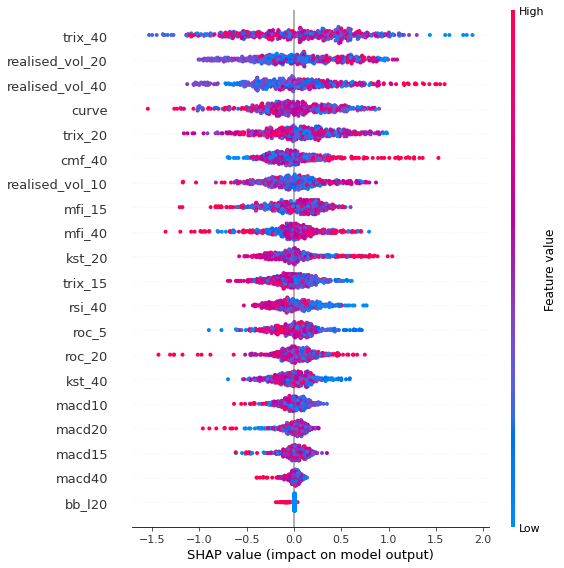

In [55]:
shap.summary_plot(shap_values, X_test_new)

In [56]:
predict = model_opt.predict(X_test_new)

cm=confusion_matrix(test_labels,predict)

Confusion Matrix


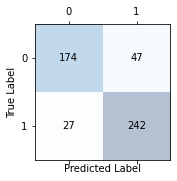

In [57]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()